# Lab 2 - Glødetråd

In [71]:
import numpy as np
import matplotlib.pyplot as plt

In [72]:
file = 'D:/Documents2/WorkspaceVScode/sebastjr/lab2data.csv'
V = [] # Lampe spenning [V]
I = [] # Lampe strøm [A]
V_s = [] # Sensor spenning [mV]
R = np.array([]) # Lampe Resistans [Ohm]
R_0 = 0.23 # Lampe motstand ved romtemp. [Ohm]
sigma = 5.670374419*10**(-8) # Stefan-Boltzmann konstant [W m^-2 K^-4]

def j(t):
    return sigma*t**4

In [73]:
with open(file, 'r') as f:
    next(f) # Skipper første linje

    for line in f: # Går linje for linje og eksporterer data
            column = line.split(',') # csv fil - komma separerer data
            V.append(float(column[0])) # V
            I.append(float(column[1])) # A
            V_s.append(float(column[2])) # mV

V = np.array(V)
I = np.array(I)
V_s = np.array(V_s)

R = V/I # Finner resistansen i lampen
R = R/R_0
print(R)

# Bruker tabell for å finne temperaturer

T = np.array([1500, 1800, 2050, 2250, 2450, 2600, 2750, 2850, 3000, 3100, 3200])
T_anal = np.linspace(1500, 3250, 100)

[ 7.04092072  8.86171498 10.24664032 11.56521739 12.57871064 13.70544458
 14.45283714 15.3847481  16.13762668 16.89751553 17.53821042]


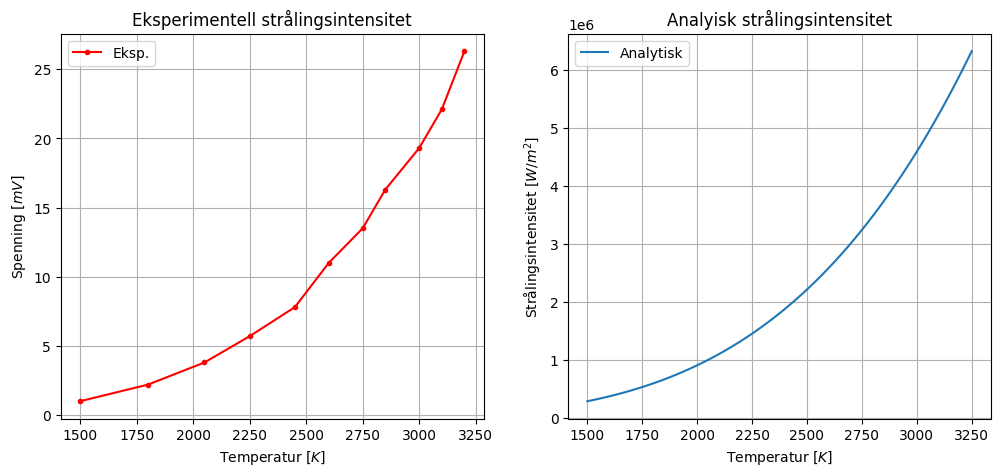

In [103]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(T, V_s, label = 'Eksp.', color = 'r', marker = '.')
plt.xlabel('Temperatur [$K$]')
plt.ylabel('Spenning [$mV$]')
plt.grid()
plt.legend()
plt.title('Eksperimentell strålingsintensitet')

plt.subplot(1, 2, 2)
plt.plot(T_anal, j(T_anal), label = 'Analytisk')
plt.xlabel('Temperatur [$K$]')
plt.ylabel('Strålingsintensitet [$W/m^2$]')
plt.grid()
plt.legend()
plt.title('Analyisk strålingsintensitet')

plt.show()